In [4]:
from IPython.display import Image

# LLaMA

Llama (Large Language Model Meta AI, formerly stylized as LLaMA) is a family of large language models (LLMs) released by Meta AI starting in February 2023. LLaMA is a decoder-only Transformer model inspired by GPT, with key architectural differences for efficiency and performance. 

## Model architecture

The LLaMA model incorporates the following technical components:


1. Transformer Block Overview
Each block consists of:
- Pre-normalization: LayerNorm before attention/MLP ($x = x + F(LN(x))$)
- Multi-Head Attention:
  - Self-Attention: Causal (autoregressive) self-attention.
  - RoPE (Rotary Positional Embeddings) for positional encoding.
    - Relative positions: RoPE allows attention scores to encode relative position differences, which helps generalize better to longer sequences.
    - No extra learnable embeddings: It works directly in the attention space without adding positional embeddings.
    - Extrapolation: Since RoPE uses sinusoidal functions, it extrapolates to longer context windows more gracefully than absolute embeddings. 
- Feedforward Network (FFN):
  - Two linear layers with GELU or SwiGLU (SiLU activation + Gated Linear Unit) non-linearity.
  - Often of the form: $FFN(x) = W3 * (GELU(W1 * x) ⊙ W2 * x)$ for SwiGLU.
  - You can think of SwiGLU ($SwiGLU(x1​,x2​)=x1​⋅SiLU(x2​)$) as:
    - $x_1$: the main signal
    - $x_2$: a gate that controls how much of the signal to keep, with smooth gating via SiLU
- Residual Connections and RMSNorm at key points.
- Advantages of RMSNorm
  - No centering → less computation
  - Stable training for large-scale models
  - Works great in practice (used in LLaMA, BLOOM, etc.)




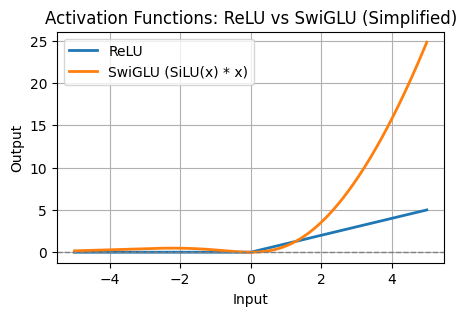

In [5]:
display(Image(filename="SwiGLU.png"))

2. Rotary Positional Embedding (RoPE)
- Instead of absolute or learned positional embeddings, LLaMA uses rotary embeddings:
  - Injects position via rotation in complex space.
  - Maintains compatibility with attention dot-product and preserves relative positions.
  - Efficient and improves extrapolation/generalization.

3. Tokenizer
- Uses SentencePiece with Byte-Pair Encoding (BPE).

4. Model Size

| Model	| #Layers	| Hidden Dim |	Heads	| FFN Dim |	Params |
| --- | --- | --- | --- | --- | --- |
| LLaMA-7B |	32	| 4096 |	32 |	11008 |	~6.7B |
|LLaMA-13B |	40 |	5120 |	40 | 	13824 |	~13B|
|LLaMA-30B |	60 |	6656 |	52|	17920 |	~30B|
|LLaMA-65B |	80 |	8192 |	64 |	22016 |	~65B|

## Training Methodology
1. Causal Language Modeling (CLM) / Next-token prediction

- Predict the next token given all previous tokens
- $L = - \sum_{T}^{t=1} log P(x_t | x_{<t})$

2. Training Data
Extensive web-crawled corpora, deduplicated and filtered. Includes:
- English CommonCrawl (filtered)
- Github, Wikipedia, ArXiv, Books, Stack Exchange, etc.
- Mixture proportions optimized for downstream performance.
- Total tokens: ~1.4 trillion (for LLaMA-65B).

3. Tokenizer and Sequence Length
- Max context length: 2048 tokens (LLaMA-1), extended to 4096 in LLaMA-2 and to 8192 in LLaMA-3.

4. Optimizer
AdamW optimizer with:
- β1 = 0.9, β2 = 0.95, ε = 1e-5
- Weight decay = 0.1
- Gradient Clipping: Global norm clipping at 1.0

5. Learning Rate Schedule
- Cosine decay with warm-up.
- Warm-up steps ≈ 2000
- Initial LR ≈ 3e-4 to 1e-4 depending on model size.

6. Batching and Precision
- Large batch sizes using ZeRO, FSDP, pipeline and tensor parallelism.
- Mixed precision training with bfloat16 and sometimes FP16.
- Gradient accumulation and data parallelism across GPUs.

7. Regularization
- Dropout: Minimal or none.
- Weight decay applied to all weights except LayerNorm and biases.



In [6]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sentencepiece as spm
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [7]:
sample_text = """
To be, or not to be, that is the question:
Whether 'tis nobler in the mind to suffer
The slings and arrows of outrageous fortune,
Or to take arms against a sea of troubles
And by opposing end them.
"""

with open("sample_data.txt", "w") as f:
    f.write(sample_text)

# if not os.path.exists("llama_tokenizer.model"):
spm.SentencePieceTrainer.train(
    input='sample_data.txt',
    model_prefix='llama_tokenizer',
    vocab_size=263,
    model_type='bpe',
    pad_id=0,
    unk_id=1,
    bos_id=2,
    eos_id=3
)

sp = spm.SentencePieceProcessor()
sp.load("llama_tokenizer.model")
real_vocab_size = sp.get_piece_size() 
print(real_vocab_size)

263


In [8]:
def apply_rope(x, sin, cos):
    # getting each even-index element
    x1 = x[..., ::2]

    # getting each odd-index element
    x2 = x[..., 1::2]

    sin = sin[..., :x1.size(-1)]
    cos = cos[..., :x1.size(-1)]
    return torch.cat([x1 * cos - x2 * sin, x1 * sin + x2 * cos], dim=-1)

def precompute_rope(seq_len, dim, base=10000):
    theta = 1.0 / (base ** (torch.arange(0, dim, 2).float() / dim))
    pos = torch.arange(seq_len).float()

    # computing the outer product between the pos vector and the theta vector 
    freqs = torch.einsum('i,j->ij', pos, theta)
    return torch.sin(freqs), torch.cos(freqs)

class RMSNorm(nn.Module):
    def __init__(self, dim, eps=1e-6):
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x):
        norm = x.norm(dim=-1, keepdim=True) * (1.0 / math.sqrt(x.shape[-1]))
        return self.scale * x / (norm + self.eps)

class SwiGLU(nn.Module):
    def __init__(self, dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(dim, hidden_dim * 2, bias=False)
        self.fc2 = nn.Linear(hidden_dim, dim, bias=False)

    def forward(self, x):
        x1, x2 = self.fc1(x).chunk(2, dim=-1)
        return self.fc2(F.silu(x1) * x2)

In [9]:
class CausalSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads, max_len=2048):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        assert d_model % num_heads == 0

        self.w_q = nn.Linear(d_model, d_model, bias=False)
        self.w_k = nn.Linear(d_model, d_model, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)
        self.out_proj = nn.Linear(d_model, d_model, bias=False)

        sin, cos = precompute_rope(max_len, self.head_dim)
        self.register_buffer("rope_sin", sin, persistent=False)
        self.register_buffer("rope_cos", cos, persistent=False)

    def forward(self, x, mask=None):
        B, T, D = x.shape
        q = self.w_q(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.w_k(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.w_v(x).view(B, T, self.num_heads, self.head_dim).transpose(1, 2)

        sin = self.rope_sin[:T].unsqueeze(0).unsqueeze(0)
        cos = self.rope_cos[:T].unsqueeze(0).unsqueeze(0)

        q = apply_rope(q, sin, cos)
        k = apply_rope(k, sin, cos)

        attn_scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.head_dim)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, float("-inf"))
        attn_weights = F.softmax(attn_scores, dim=-1)

        attn_output = torch.matmul(attn_weights, v)
        attn_output = attn_output.transpose(1, 2).contiguous().view(B, T, D)

        return self.out_proj(attn_output)

class DecoderBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, max_len):
        super().__init__()
        self.ln1 = RMSNorm(d_model)
        self.attn = CausalSelfAttention(d_model, num_heads, max_len)
        self.ln2 = RMSNorm(d_model)
        self.ff = SwiGLU(d_model, d_ff)

    def forward(self, x, mask=None):
        x = x + self.attn(self.ln1(x), mask)
        x = x + self.ff(self.ln2(x))
        return x

class LLaMALikeTransformer(nn.Module):
    def __init__(self, vocab_size, d_model=128, num_heads=4, num_layers=2, d_ff=256, max_len=2048):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.blocks = nn.ModuleList([DecoderBlock(d_model, num_heads, d_ff, max_len) for _ in range(num_layers)])
        self.ln_f = RMSNorm(d_model)
        self.output = nn.Linear(d_model, vocab_size, bias=False)

    def forward(self, x):
        x = self.embedding(x)
        mask = torch.tril(torch.ones(x.size(1), x.size(1), device=x.device)).unsqueeze(0).unsqueeze(0)
        for block in self.blocks:
            x = block(x, mask)
        return self.output(self.ln_f(x))


class LLaMADataset(Dataset):
    def __init__(self, text, tokenizer, seq_len):
        self.ids = tokenizer.encode(text, out_type=int)
        self.seq_len = seq_len

    def __len__(self):
        return len(self.ids) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.ids[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.ids[idx + 1:idx + self.seq_len + 1], dtype=torch.long)
        return x, y


def train_model(model, dataloader, device, epochs=10, lr=3e-4, warmup_steps=10):
    optimizer = optim.AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), eps=1e-5, weight_decay=0.1)
    scaler = GradScaler()
    loss_fn = nn.CrossEntropyLoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(dataloader)*epochs, eta_min=1e-5)
    model.train()
    loss_history = []
    global_step = 0

    for epoch in range(epochs):
        pbar = tqdm(dataloader, desc=f"Epoch {epoch+1}")
        total_loss = 0
        for x, y in pbar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()

            with autocast(device):
                logits = model(x)
                loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_loss += loss.item()
            loss_history.append(loss.item())
            pbar.set_postfix(loss=total_loss / (pbar.n + 1))
            global_step += 1

    # Plot loss
    plt.plot(loss_history)
    plt.title("Training Loss")
    plt.xlabel("Steps")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()


def save_checkpoint(model, path="llama_tiny.pt"):
    torch.save(model.state_dict(), path)


def load_checkpoint(model, path="llama_tiny.pt"):
    model.load_state_dict(torch.load(path))
    model.eval()

/home/frank/miniconda3/envs/llm_fine_tuning/lib/python3.11/site-packages/torch/cuda/__init__.py:716: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
Epoch 10: 100%|██████████████████████████████████████████████| 15/15 [00:00<00:00, 150.26it/s, loss=5.78]


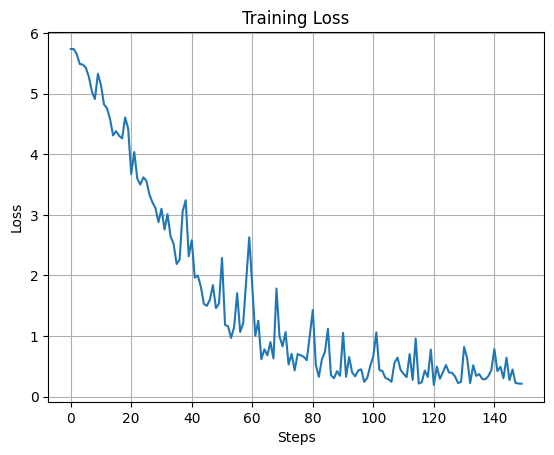

In [10]:
with open("sample_data.txt", "r") as f:
    raw_text = f.read()

seq_len = 16
batch_size = 2
dataset = LLaMADataset(raw_text, sp, seq_len)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LLaMALikeTransformer(vocab_size=real_vocab_size).to(device)

train_model(model, dataloader, device)
save_checkpoint(model)

## Perplexity

Perplexity is a measurement of how well a language model predicts a sample. It quantifies the uncertainty or "surprise" of the model when seeing the actual next token.

Definition (for a sequence of tokens): $Perplexity = 𝑒^{CrossEntropyLoss}$, where:
- Cross-entropy is the average log-loss over the predicted probabilities for the correct next token.
- Lower perplexity = better model (more confident predictions).

Interpretation:
- Perplexity of 1.0 → the model is perfectly confident and always correct.
- Perplexity of 10.0 → on average, the model is as uncertain as randomly choosing from 10 equally likely tokens.
- If your model has a perplexity of ~1000, and your vocabulary has 1000 tokens, it’s essentially guessing.

In [11]:
def evaluate_perplexity(model, dataloader):
    model.eval()
    loss_fn = nn.CrossEntropyLoss()
    total_loss = 0.0
    total_tokens = 0
    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item() * x.size(0)
            total_tokens += x.size(0)
    return math.exp(total_loss / total_tokens)

print("\nValidation Perplexity:", evaluate_perplexity(model, dataloader))


Validation Perplexity: 1.4699743039562132


## Visualization

- Each point in the t-SNE plot is a token (or subword unit) from the tokenizer.
- For tokens that are close together, the model has learned that they are semantically or syntactically similar.
- For tokens that are farther away, the model sees them as unrelated or used in very different contexts.



In [12]:
def visualize_embeddings(model, tokenizer, num_tokens=100):
    # Get embedding weights
    weights = model.embedding.weight[:num_tokens].detach().cpu().numpy()
    labels = [tokenizer.id_to_piece(i) for i in range(num_tokens)]

    # Reduce dimensions
    tsne = TSNE(n_components=2, perplexity=15, random_state=42)
    reduced = tsne.fit_transform(weights)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(reduced[:, 0], reduced[:, 1])
    for i, label in enumerate(labels):
        plt.annotate(label, (reduced[i, 0], reduced[i, 1]), fontsize=8)
    plt.title("Token Embeddings Visualized via t-SNE")
    plt.grid(True)
    plt.show()

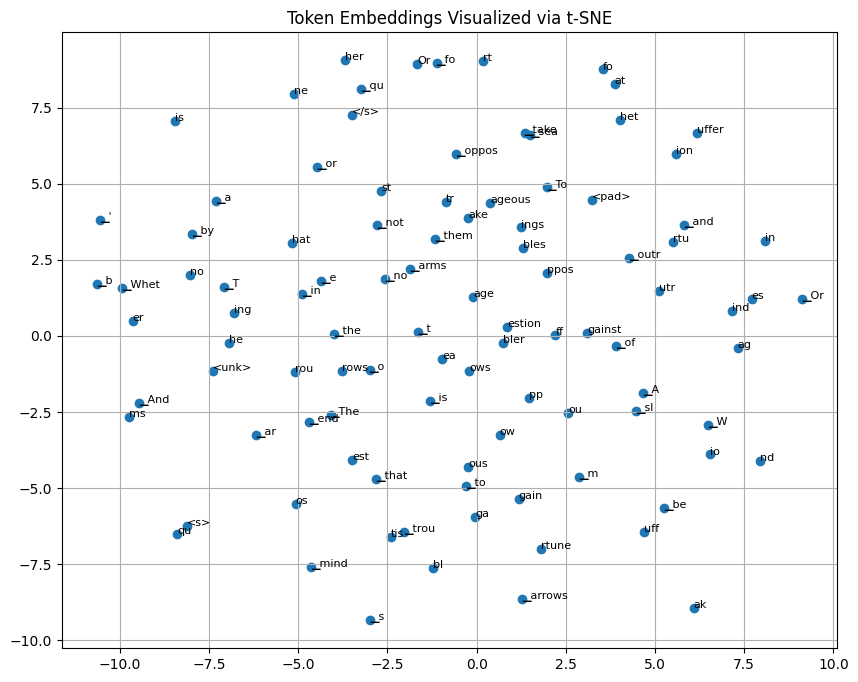

In [13]:
visualize_embeddings(model, sp, num_tokens=100)

## Generation

In [14]:
def top_k_top_p_filtering(logits, vocab_size, top_k=0, top_p=0.9, filter_value=-float('Inf')):
    logits = logits[:vocab_size]
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    cumulative_probs = torch.softmax(sorted_logits, dim=-1).cumsum(dim=-1)

    if top_p > 0.0:
        sorted_indices_to_remove = cumulative_probs > top_p
        sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[..., :-1].clone()
        sorted_indices_to_remove[..., 0] = 0
        indices_to_remove = sorted_indices[sorted_indices_to_remove]
        logits[indices_to_remove] = filter_value

    if top_k > 0:
        top_k = min(top_k, logits.size(-1))
        indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
        logits[indices_to_remove] = filter_value

    return logits

def generate(model, tokenizer, prompt, max_len=50, top_k=40, top_p=0.9, temperature=1.0):
    model.eval()
    vocab_size = tokenizer.get_piece_size()

    ids = tokenizer.encode(prompt, out_type=int)
    input_ids = torch.tensor(ids, dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(max_len):
        with torch.no_grad():
            logits = model(input_ids)
            logits = logits[:, -1, :vocab_size] / temperature

            filtered_logits = top_k_top_p_filtering(logits.squeeze(), vocab_size=vocab_size, top_k=top_k, top_p=top_p)
            probs = torch.softmax(filtered_logits, dim=-1)
            next_token = torch.multinomial(probs, num_samples=1)

        input_ids = torch.cat([input_ids, next_token.unsqueeze(0)], dim=1)

    token_ids = input_ids.squeeze().tolist()
    return tokenizer.decode(token_ids)

In [15]:
print("\nGenerated Text:")
print(generate(model, sp, "To be"))


Generated Text:
To be, sea of troubles Or to suffer The slings andkrowsgainows suff and arrows of outrageous fortune, Or tominows, Or to takef the mind to endminthe, Or Whether 'tis nobler in that is the mind to take


## Supplement: ReLU vs SwiGLU

In [16]:
if False:
    import torch
    import torch.nn.functional as F
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Define x input range
    x = torch.linspace(-5, 5, 1000)
    
    # ReLU
    relu = F.relu(x)
    
    # SiLU (a.k.a. Swish)
    silu = F.silu(x)
    
    # SwiGLU-style activation (simplified visualization)
    # Assume x1 = x2 = x to simplify
    swiglu = F.silu(x) * x
    
    # Plotting
    plt.figure(figsize=(5, 3))
    plt.plot(x.numpy(), relu.numpy(), label='ReLU', linewidth=2)
    plt.plot(x.numpy(), swiglu.numpy(), label='SwiGLU (SiLU(x) * x)', linewidth=2)
    plt.axhline(0, color='gray', linestyle='--', linewidth=1)
    plt.title("Activation Functions: ReLU vs SwiGLU (Simplified)")
    plt.xlabel("Input")
    plt.ylabel("Output")
    plt.legend()
    plt.grid(True)
    plt.show()